# Imports and misc

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/AIML"

Mounted at /content/drive
boston_house_prices.csv  diabetes.csv	   marks_it2011.pdf
brain_tumor_dataset	 diabetes.tab.txt  marks_se2030.pdf
cars_data.csv		 Income.csv	   student_data.csv


In [2]:
dataset_path = "/content/drive/MyDrive/AIML/brain_tumor_dataset"

In [3]:
!pip install mplcyberpunk

In [4]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

# Preparing data

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
image_size = 256

# Training set
for i in labels:
    folderPath = os.path.join(dataset_path, 'Training', i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading {i} (Training)"):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# Testing set
for i in labels:
    folderPath = os.path.join(dataset_path, 'Testing', i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading {i} (Testing)"):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)      # ✅ Fixed
        y_test.append(i)        # ✅ Fixed

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Data successfully loaded from Google Drive ✅")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Loading pituitary_tumor (Testing): 100%|██████████| 74/74 [00:21<00:00,  3.52it/s]


Data successfully loaded from Google Drive ✅
X_train shape: (2876, 256, 256, 3)
y_train shape: (2876,)
X_test shape:  (394, 256, 256, 3)
y_test shape:  (394,)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2876, 256, 256, 3)
X_test shape: (394, 256, 256, 3)
y_train shape: (2876,)
y_test shape: (394,)


**Glioma Tumor:**
>Originating in the brain or spine's glial cells, gliomas represent 30% of all brain and central nervous system tumors. They are mostly malignant, with symptoms that vary depending on location, frequently resulting in seizures, cognitive impairments, or motor deficits.

**Meningioma Tumor:**
>Meningiomas, arising from the meninges enveloping the brain and spinal cord, are slow-growing tumors. While they typically are asymptomatic, they can cause seizures, cognitive decline, vision disturbances, or motor deficits depending on their location.

**Pituitary Tumor:**
>Pituitary adenomas, mostly benign, occur in the pituitary gland, accounting for 10-25% of intracranial neoplasms. They may cause hormonal imbalances, resulting in a variety of symptoms including headaches, vision changes, or hormonal dysfunctions.


# Visualization

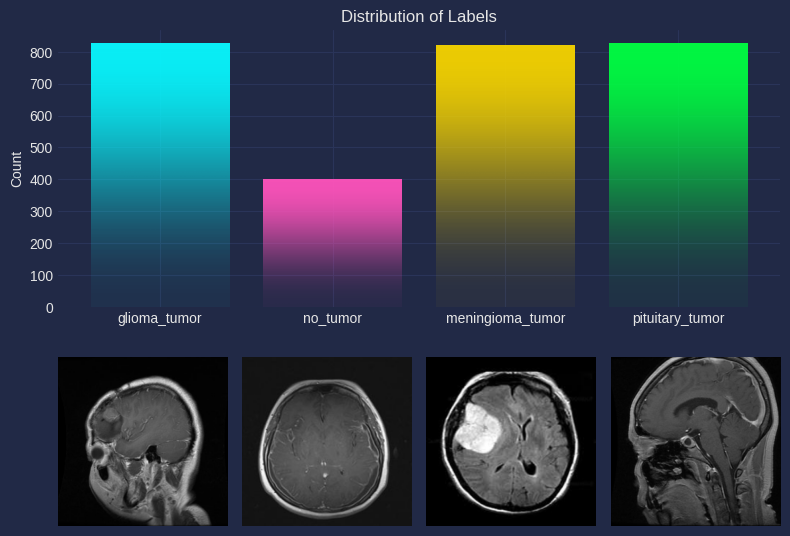

In [ ]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

# Applying CLAHE

In [7]:
# -------------------------------
# Preparing data with CLAHE
# -------------------------------

X_train = []
y_train = []
X_test = []
y_test = []

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
image_size = 256

# Initialize CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Function to apply CLAHE
def apply_clahe(img):
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L channel
    l_clahe = clahe.apply(l)

    # Merge channels back
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    return img_clahe

# Training set
for i in labels:
    folderPath = os.path.join(dataset_path, 'Training', i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading {i} (Training)"):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is None:  # skip bad images
            continue
        img = apply_clahe(img)   # ✅ CLAHE step added
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# Testing set
for i in labels:
    folderPath = os.path.join(dataset_path, 'Testing', i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading {i} (Testing)"):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is None:
            continue
        img = apply_clahe(img)   # ✅ CLAHE step added
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Data with CLAHE successfully loaded ✅")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")



Loading pituitary_tumor (Testing): 100%|██████████| 74/74 [00:01<00:00, 38.79it/s]


Data with CLAHE successfully loaded ✅
X_train shape: (2876, 256, 256, 3)
y_train shape: (2876,)
X_test shape:  (394, 256, 256, 3)
y_test shape:  (394,)


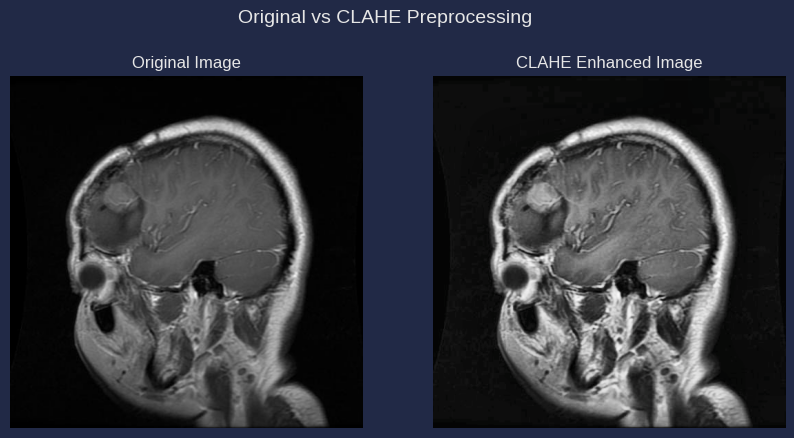

In [12]:
# -------------------------------
# Visualize Original vs CLAHE
# -------------------------------

import matplotlib.pyplot as plt

# Pick a sample image from one of the folders
sample_path = os.path.join(dataset_path, "Training", "glioma_tumor")
sample_img = cv2.imread(os.path.join(sample_path, os.listdir(sample_path)[0]))

# Apply CLAHE
clahe_img = apply_clahe(sample_img)

# Convert BGR (OpenCV) -> RGB (matplotlib)
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
clahe_img_rgb  = cv2.cvtColor(clahe_img, cv2.COLOR_BGR2RGB)

# Show side-by-side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(sample_img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(clahe_img_rgb)
plt.title("CLAHE Enhanced Image")
plt.axis("off")

plt.suptitle("Original vs CLAHE Preprocessing", fontsize=14)
plt.show()


# Encoding


In [ ]:
# Convert y_train labels to one-hot encoded format using pandas
y_train = np.array(pd.get_dummies(y_train))

In [ ]:
#Split the dataset into training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_train shape: {(X_test).shape}\n'
      f'y_train shape: {(y_test).shape}\n'
      f'y_train shape: {(X_valid).shape}\n'
      f'X_train shape: {(y_valid).shape}')

X_train shape: (2329, 256, 256, 3)
y_train shape: (2329, 4)
X_train shape: (288, 256, 256, 3)
y_train shape: (288, 4)
y_train shape: (259, 256, 256, 3)
X_train shape: (259, 4)


# Data augmentation

📌 **Data augmentation** is an important technique in deep learning for increasing and diversifying existing datasets. Instead of collecting new data, it involves transforming existing data to generate variations. This approach addresses the need for large and diverse datasets, which are required to train robust deep learning models. By augmenting the data, we can effectively increase dataset sizes and diversity, thereby improving the model's ability to generalize to different scenarios.

<p>&nbsp;</p>

*Source:[geeksforgeeks](https://www.geeksforgeeks.org/python-data-augmentation/)*

Overly extreme augmentation parameters can distort images, limiting the model's ability to generalize. For example, excessive rotation or zooming can obscure important image features, resulting in misclassifications.

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

datagen.fit(X_train)

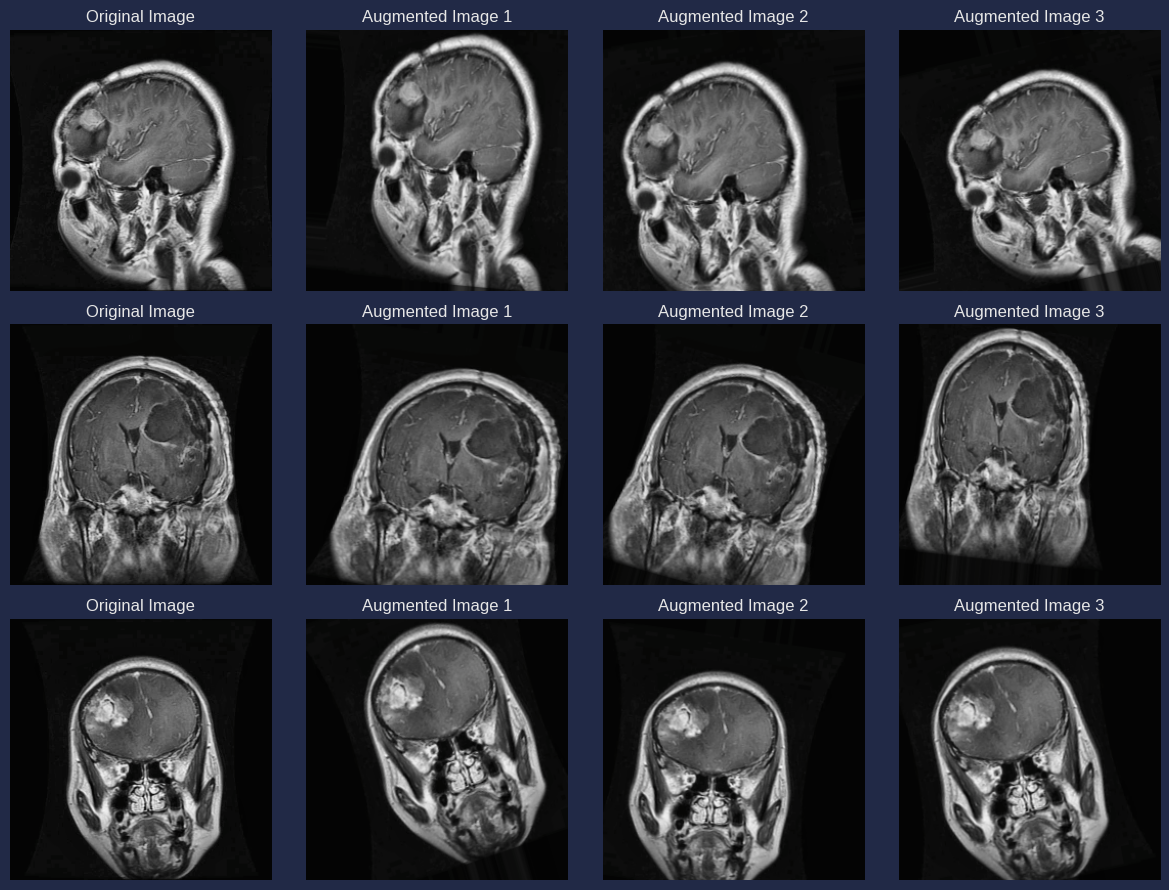

In [10]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:

        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

# Normalization

In [ ]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


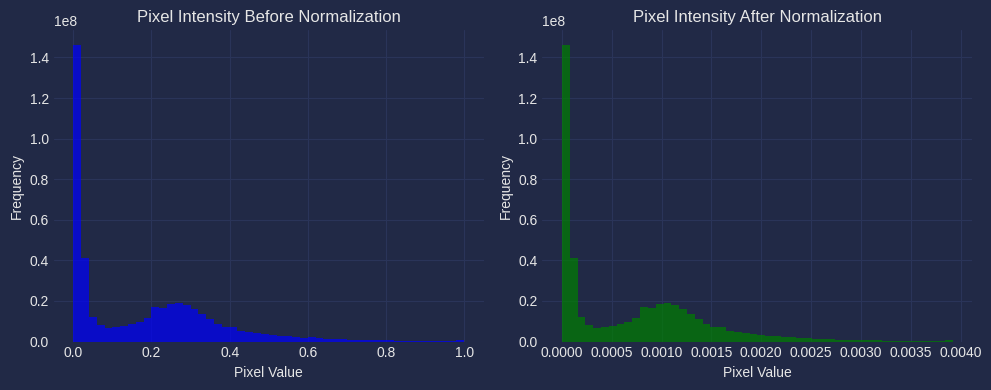

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(X_train.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Before Normalization")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist((X_train/255).ravel(), bins=50, color='green', alpha=0.7)
plt.title("Pixel Intensity After Normalization")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# Feature Selection

✅ VGG16 loaded successfully
✅ Preprocessing function ready
Train resized shape: (2329, 224, 224, 3)
Test resized shape: (288, 224, 224, 3)
Train features shape: (2329, 25088)
Test features shape: (288, 25088)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.1min finished



✅ Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.70      0.77      0.74        88
        no_tumor       0.65      0.64      0.65        84
meningioma_tumor       0.83      0.62      0.71        48
 pituitary_tumor       0.83      0.88      0.86        68

        accuracy                           0.74       288
       macro avg       0.75      0.73      0.74       288
    weighted avg       0.74      0.74      0.73       288



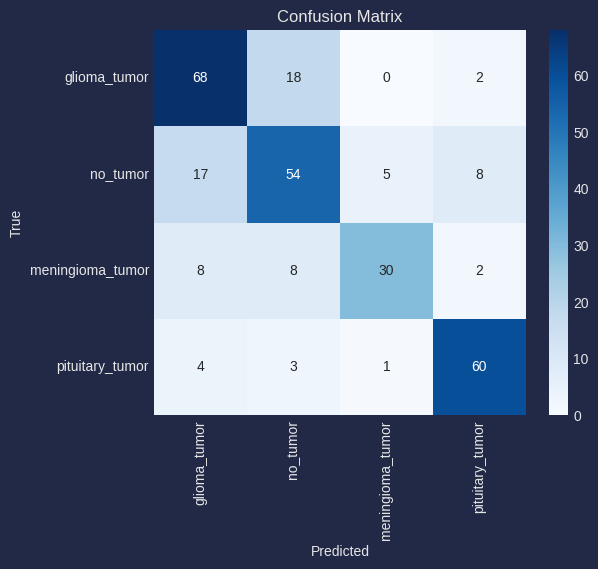

In [ ]:
# -------------------------------
# STEP 1: Imports
# -------------------------------
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# STEP 2: Load Pretrained VGG16
# -------------------------------
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Define feature extractor
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

print("✅ VGG16 loaded successfully")

# -------------------------------
# STEP 3: Batch Preprocessing
# -------------------------------
def preprocess_images_in_batches(X, batch_size=64, target_size=(224, 224)):
    """
    Resize and preprocess images in batches to avoid memory crash.
    """
    processed = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        batch = tf.convert_to_tensor(batch)
        batch = tf.image.resize(batch, target_size)   # Resize to 224x224
        batch = preprocess_input(batch.numpy())       # Apply VGG16 preprocessing
        processed.append(batch)
    return np.vstack(processed)

print("✅ Preprocessing function ready")

# -------------------------------
# STEP 4: Preprocess Train & Test
# -------------------------------
X_train_resized = preprocess_images_in_batches(X_train, batch_size=64)
X_test_resized  = preprocess_images_in_batches(X_test, batch_size=64)

print("Train resized shape:", X_train_resized.shape)
print("Test resized shape:", X_test_resized.shape)

# -------------------------------
# STEP 5: Feature Extraction
# -------------------------------
def extract_features_in_batches(model, X, batch_size=32):
    """
    Extract features in batches to stay memory safe.
    """
    features = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        batch_features = model.predict(batch, verbose=0)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # flatten
        features.append(batch_features)
    return np.vstack(features)

train_features = extract_features_in_batches(feature_extractor, X_train_resized, batch_size=32)
test_features  = extract_features_in_batches(feature_extractor, X_test_resized, batch_size=32)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

# -------------------------------
# STEP 6: Train Classifier
# -------------------------------
# Convert one-hot labels back to class indices
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels  = np.argmax(y_test, axis=1)

clf = LogisticRegression(max_iter=1000, verbose=1)
clf.fit(train_features, y_train_labels)

y_pred = clf.predict(test_features)

print("\n✅ Classification Report:\n")
print(classification_report(y_test_labels, y_pred, target_names=labels))

# -------------------------------
# STEP 7: Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#The End